C:\Users\ASUS\AppData\Local\Temp\ipykernel_15448\201577474.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  period_returns_yearly = merged_df.groupby(['Year', 'Period', 'Period_Order']).apply(


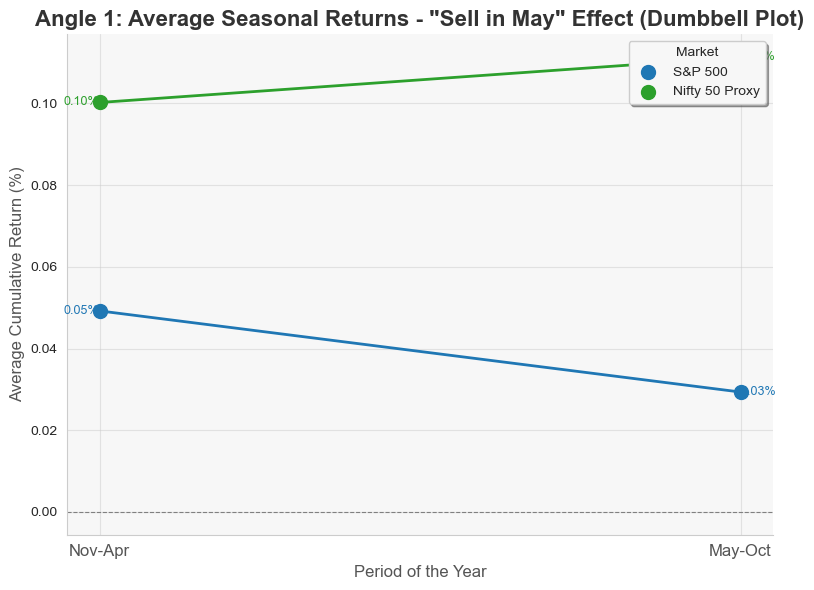

Sell in May and Go Away Strategy: Angle 1 (Dumbbell Plot) generated and saved as 'sell_in_may_angle1_dumbbell_chart.png'


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Datasets ---
try:
    sp500_df = pd.read_csv('SPX.csv', parse_dates=['Date'])
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
except FileNotFoundError:
    print("Error: Make sure 'SPX.csv' and 'Final-50-stocks.csv' are in the same directory as this script.")
    print("Please ensure the files are correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Data Preprocessing ---

# S&P 500 Data: Select 'Date' and 'Adj Close' and calculate returns
sp500_df = sp500_df[['Date', 'Adj Close']].copy()
sp500_df.columns = ['Date', 'SP500_Close']
sp500_df = sp500_df.sort_values(by='Date').set_index('Date')
sp500_df['SP500_Returns'] = sp500_df['SP500_Close'].pct_change().dropna()

# Nifty 50 Data: Calculate a proxy for Nifty 50 Index and its returns
nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
if 'Date' in stock_tickers:
    stock_tickers.remove('Date')

for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

nifty50_stocks_df['Nifty50_Proxy_Close'] = nifty50_stocks_df[stock_tickers].mean(axis=1)
nifty50_proxy_df = nifty50_stocks_df[['Nifty50_Proxy_Close']].copy()
nifty50_proxy_df.columns = ['Nifty50_Close']
nifty50_proxy_df['Nifty50_Returns'] = nifty50_proxy_df['Nifty50_Close'].pct_change().dropna()

# Merge the datasets on 'Date' (index)
merged_df = pd.merge(sp500_df, nifty50_proxy_df, on='Date', how='inner')

# Filter for relevant date range (Nifty 50 data starts from 2010)
merged_df = merged_df.loc['2010-01-01':]

# --- 3. Define "Sell in May" Periods and Calculate Annual Period Returns ---

# Assign each row to a period: 'May-Oct' or 'Nov-Apr'
merged_df['Month'] = merged_df.index.month
merged_df['Period'] = np.where(
    (merged_df['Month'] >= 5) & (merged_df['Month'] <= 10),
    'May-Oct',
    'Nov-Apr'
)
merged_df['Period_Order'] = np.where(merged_df['Period'] == 'Nov-Apr', 0, 1) # For consistent sorting in plots

# Create a 'Year' column for grouping
merged_df['Year'] = merged_df.index.year

# Calculate daily growth factor (1 + return)
merged_df['SP500_Growth_Factor'] = 1 + (merged_df['SP500_Returns'] / 100)
merged_df['Nifty50_Growth_Factor'] = 1 + (merged_df['Nifty50_Returns'] / 100)

# Calculate cumulative return for each period within each year
period_returns_yearly = merged_df.groupby(['Year', 'Period', 'Period_Order']).apply(
    lambda x: pd.Series({
        'SP500_Cumulative_Return': (x['SP500_Growth_Factor'].prod() - 1) * 100,
        'Nifty50_Cumulative_Return': (x['Nifty50_Growth_Factor'].prod() - 1) * 100
    })
).reset_index()

# Drop any periods/years where the cumulative return calculation resulted in NaN
period_returns_yearly = period_returns_yearly.dropna(subset=['SP500_Cumulative_Return', 'Nifty50_Cumulative_Return'])


# --- Set Global Plotting Style ---
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})


# --- Angle 1: Average Cumulative Return (Dumbbell Plot) ---

# Calculate the average cumulative return for each period across all years
average_period_returns = period_returns_yearly.groupby('Period')[['SP500_Cumulative_Return', 'Nifty50_Cumulative_Return']].mean().reset_index()

# --- FIX FOR KEYERROR: Melt average_period_returns to create 'Market' column before pivoting ---
plot_df_angle1_melted = average_period_returns.melt(
    id_vars='Period',
    var_name='Market',
    value_name='Average Cumulative Return (%)'
)

# Reshape data for dumbbell plot
# Now 'Market' column exists, and we pivot to get Nov-Apr and May-Oct returns in separate columns for each market
dumbbell_df = plot_df_angle1_melted.pivot(index='Market', columns='Period', values='Average Cumulative Return (%)').reset_index()
dumbbell_df = dumbbell_df.rename_axis(columns=None) # Remove columns index name

# Ensure consistent order for periods (Nov-Apr first, then May-Oct)
dumbbell_df = dumbbell_df[['Market', 'Nov-Apr', 'May-Oct']] # Explicitly order columns


# Extract relevant data for plotting
# Now access directly from dumbbell_df rows
sp500_data = dumbbell_df[dumbbell_df['Market'] == 'SP500_Cumulative_Return'].iloc[0]
nifty50_data = dumbbell_df[dumbbell_df['Market'] == 'Nifty50_Cumulative_Return'].iloc[0]

nov_apr_sp500 = sp500_data['Nov-Apr']
may_oct_sp500 = sp500_data['May-Oct']
nov_apr_nifty50 = nifty50_data['Nov-Apr']
may_oct_nifty50 = nifty50_data['May-Oct']


fig1, ax1 = plt.subplots(figsize=(8, 6))

# Plot lines connecting the two periods for S&P 500
ax1.plot([0, 1], [nov_apr_sp500, may_oct_sp500],
         color='#1f77b4', linewidth=2, linestyle='-', zorder=1)
# Plot points for S&P 500
ax1.scatter([0, 1], [nov_apr_sp500, may_oct_sp500],
            color='#1f77b4', s=100, zorder=2, label='S&P 500')

# Plot lines connecting the two periods for Nifty 50
ax1.plot([0, 1], [nov_apr_nifty50, may_oct_nifty50],
         color='#2ca02c', linewidth=2, linestyle='-', zorder=1)
# Plot points for Nifty 50
ax1.scatter([0, 1], [nov_apr_nifty50, may_oct_nifty50],
            color='#2ca02c', s=100, zorder=2, label='Nifty 50 Proxy')

# Add labels for points
ax1.text(0, nov_apr_sp500, f'{nov_apr_sp500:.2f}%', ha='right', va='center', fontsize=9, color='#1f77b4')
ax1.text(1, may_oct_sp500, f'{may_oct_sp500:.2f}%', ha='left', va='center', fontsize=9, color='#1f77b4')
ax1.text(0, nov_apr_nifty50, f'{nov_apr_nifty50:.2f}%', ha='right', va='center', fontsize=9, color='#2ca02c')
ax1.text(1, may_oct_nifty50, f'{may_oct_nifty50:.2f}%', ha='left', va='center', fontsize=9, color='#2ca02c')


ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Nov-Apr', 'May-Oct'], fontsize=12, color='#555555')

ax1.set_title('Angle 1: Average Seasonal Returns - "Sell in May" Effect (Dumbbell Plot)', fontsize=16, fontweight='bold', color='#333333')
ax1.set_xlabel('Period of the Year', fontsize=12, color='#555555')
ax1.set_ylabel('Average Cumulative Return (%)', fontsize=12, color='#555555')
ax1.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Zero line

ax1.legend(title='Market', loc='upper right', fontsize=10, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('sell_in_may_angle1_dumbbell_chart.png')
plt.show()
plt.close(fig1)

print("Sell in May and Go Away Strategy: Angle 1 (Dumbbell Plot) generated and saved as 'sell_in_may_angle1_dumbbell_chart.png'")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15448\4132675852.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  period_returns_yearly = merged_df.groupby(['Year', 'Period', 'Period_Order']).apply(


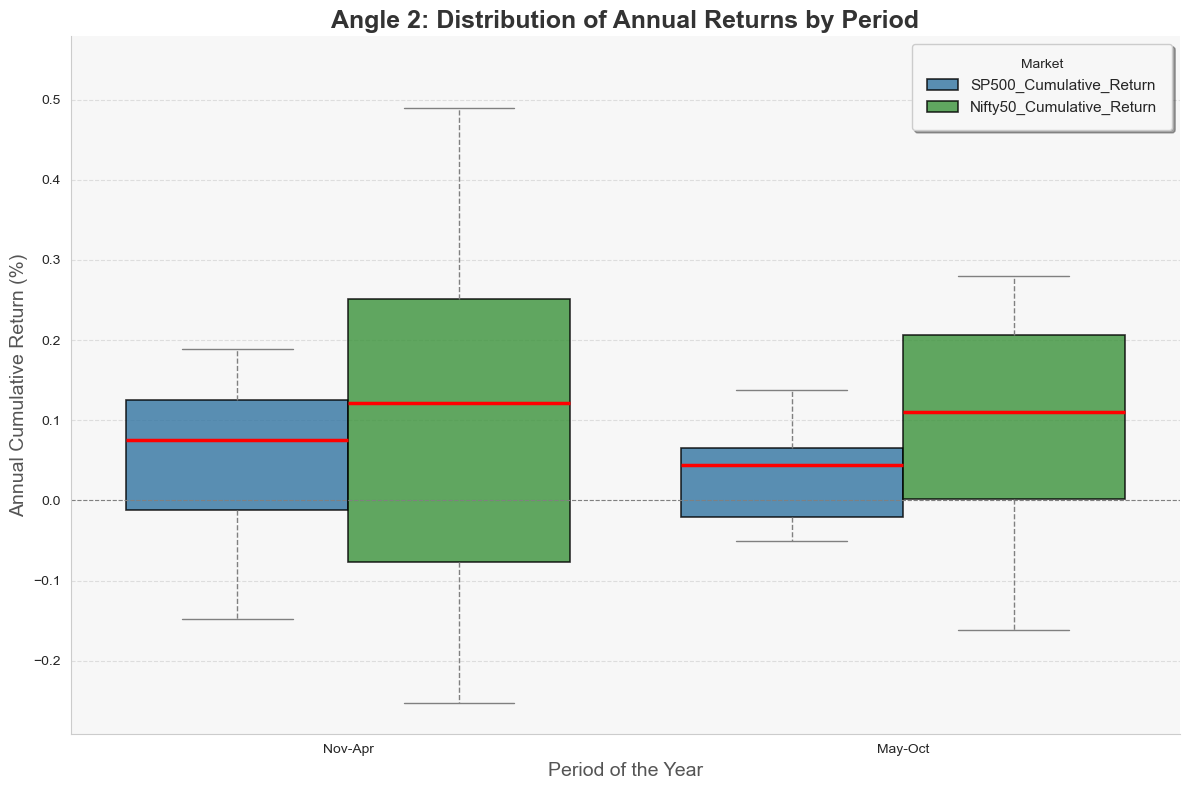

Angle 2: Distribution of Annual Returns Box Plot generated and saved with enhanced styling.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Datasets ---
try:
    sp500_df = pd.read_csv('SPX.csv', parse_dates=['Date'])
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
except FileNotFoundError:
    print("Error: Make sure 'SPX.csv' and 'Final-50-stocks.csv' are in the same directory as this script.")
    print("Please ensure the files are correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Data Preprocessing ---

# S&P 500 Data: Select 'Date' and 'Adj Close' and calculate returns
sp500_df = sp500_df[['Date', 'Adj Close']].copy()
sp500_df.columns = ['Date', 'SP500_Close']
sp500_df = sp500_df.sort_values(by='Date').set_index('Date')
sp500_df['SP500_Returns'] = sp500_df['SP500_Close'].pct_change().dropna()

# Nifty 50 Data: Calculate a proxy for Nifty 50 Index and its returns
nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
if 'Date' in stock_tickers:
    stock_tickers.remove('Date')

for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

nifty50_stocks_df['Nifty50_Proxy_Close'] = nifty50_stocks_df[stock_tickers].mean(axis=1)
nifty50_proxy_df = nifty50_stocks_df[['Nifty50_Proxy_Close']].copy()
nifty50_proxy_df.columns = ['Nifty50_Close']
nifty50_proxy_df['Nifty50_Returns'] = nifty50_proxy_df['Nifty50_Close'].pct_change().dropna()

# Merge the datasets on 'Date' (index)
merged_df = pd.merge(sp500_df, nifty50_proxy_df, on='Date', how='inner')

# Filter for relevant date range (Nifty 50 data starts from 2010)
merged_df = merged_df.loc['2010-01-01':]

# --- 3. Define "Sell in May" Periods and Calculate Annual Period Returns ---

# Assign each row to a period: 'May-Oct' or 'Nov-Apr'
merged_df['Month'] = merged_df.index.month
merged_df['Period'] = np.where(
    (merged_df['Month'] >= 5) & (merged_df['Month'] <= 10),
    'May-Oct',
    'Nov-Apr'
)
merged_df['Period_Order'] = np.where(merged_df['Period'] == 'Nov-Apr', 0, 1) # For consistent sorting in plots

# Create a 'Year' column for grouping
merged_df['Year'] = merged_df.index.year

# Calculate daily growth factor (1 + return)
merged_df['SP500_Growth_Factor'] = 1 + (merged_df['SP500_Returns'] / 100)
merged_df['Nifty50_Growth_Factor'] = 1 + (merged_df['Nifty50_Returns'] / 100)

# Calculate cumulative return for each period within each year
period_returns_yearly = merged_df.groupby(['Year', 'Period', 'Period_Order']).apply(
    lambda x: pd.Series({
        'SP500_Cumulative_Return': (x['SP500_Growth_Factor'].prod() - 1) * 100,
        'Nifty50_Cumulative_Return': (x['Nifty50_Growth_Factor'].prod() - 1) * 100
    })
).reset_index()

# Drop any periods/years where the cumulative return calculation resulted in NaN
period_returns_yearly = period_returns_yearly.dropna(subset=['SP500_Cumulative_Return', 'Nifty50_Cumulative_Return'])


# --- Set Global Plotting Style ---
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})


# --- Angle 1: Average Cumulative Return (Grouped Bar Chart) - Skipped as per user request ---
# This code block is intentionally left out to focus on Angle 2.


# --- Angle 2: Distribution of Annual Period Returns (Box Plots) ---

# Melt for plotting
plot_df_angle2 = period_returns_yearly.melt(id_vars=['Year', 'Period', 'Period_Order'], var_name='Market', value_name='Annual Cumulative Return (%)')

# Ensure correct order for periods
plot_df_angle2['Period'] = pd.Categorical(plot_df_angle2['Period'], categories=['Nov-Apr', 'May-Oct'], ordered=True)
plot_df_angle2 = plot_df_angle2.sort_values('Period')


fig2, ax2 = plt.subplots(figsize=(12, 8))

# --- Visual enhancements for box plots ---
sns.boxplot(
    data=plot_df_angle2,
    x='Period',
    y='Annual Cumulative Return (%)',
    hue='Market',
    palette={'SP500_Cumulative_Return': '#1f77b4', 'Nifty50_Cumulative_Return': '#2ca02c'}, # Blue for SP500, Green for Nifty
    ax=ax2,
    boxprops=dict(alpha=0.8, edgecolor='black', linewidth=1.2), # Increased alpha and linewidth for boxes
    medianprops=dict(color='red', linewidth=2.5), # Thicker red median line
    whiskerprops=dict(color='gray', linestyle='--', linewidth=1), # Clearer whiskers
    capprops=dict(color='gray', linewidth=1), # Clearer caps
    flierprops=dict(marker='o', markersize=6, markerfacecolor='purple', alpha=0.7, markeredgecolor='black') # More prominent outliers
)

ax2.set_title('Angle 2: Distribution of Annual Returns by Period', fontsize=18, fontweight='bold', color='#333333')
ax2.set_xlabel('Period of the Year', fontsize=14, color='#555555')
ax2.set_ylabel('Annual Cumulative Return (%)', fontsize=14, color='#555555')
ax2.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Zero line

# Enhanced legend
ax2.legend(title='Market', loc='upper right', fontsize=11, frameon=True, fancybox=True, shadow=True, borderpad=1)

# Customize grid (only y-axis grid for box plots usually)
ax2.grid(True, linestyle='--', alpha=0.6, axis='y')
ax2.grid(False, axis='x') # Turn off x-axis grid for cleaner look between groups

plt.tight_layout()
plt.savefig('sell_in_may_angle2_distribution_boxplots.png')
plt.show()
plt.close(fig2)


# --- Angle 3: Year-by-Year Comparison with Period Highlights (Line Chart with Shaded Periods) - Skipped as per user request ---
# This code block is intentionally left out to focus on Angle 2.

print("Angle 2: Distribution of Annual Returns Box Plot generated and saved with enhanced styling.")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15448\695938746.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  period_returns_yearly = merged_df.groupby(['Year', 'Period', 'Period_Order']).apply(


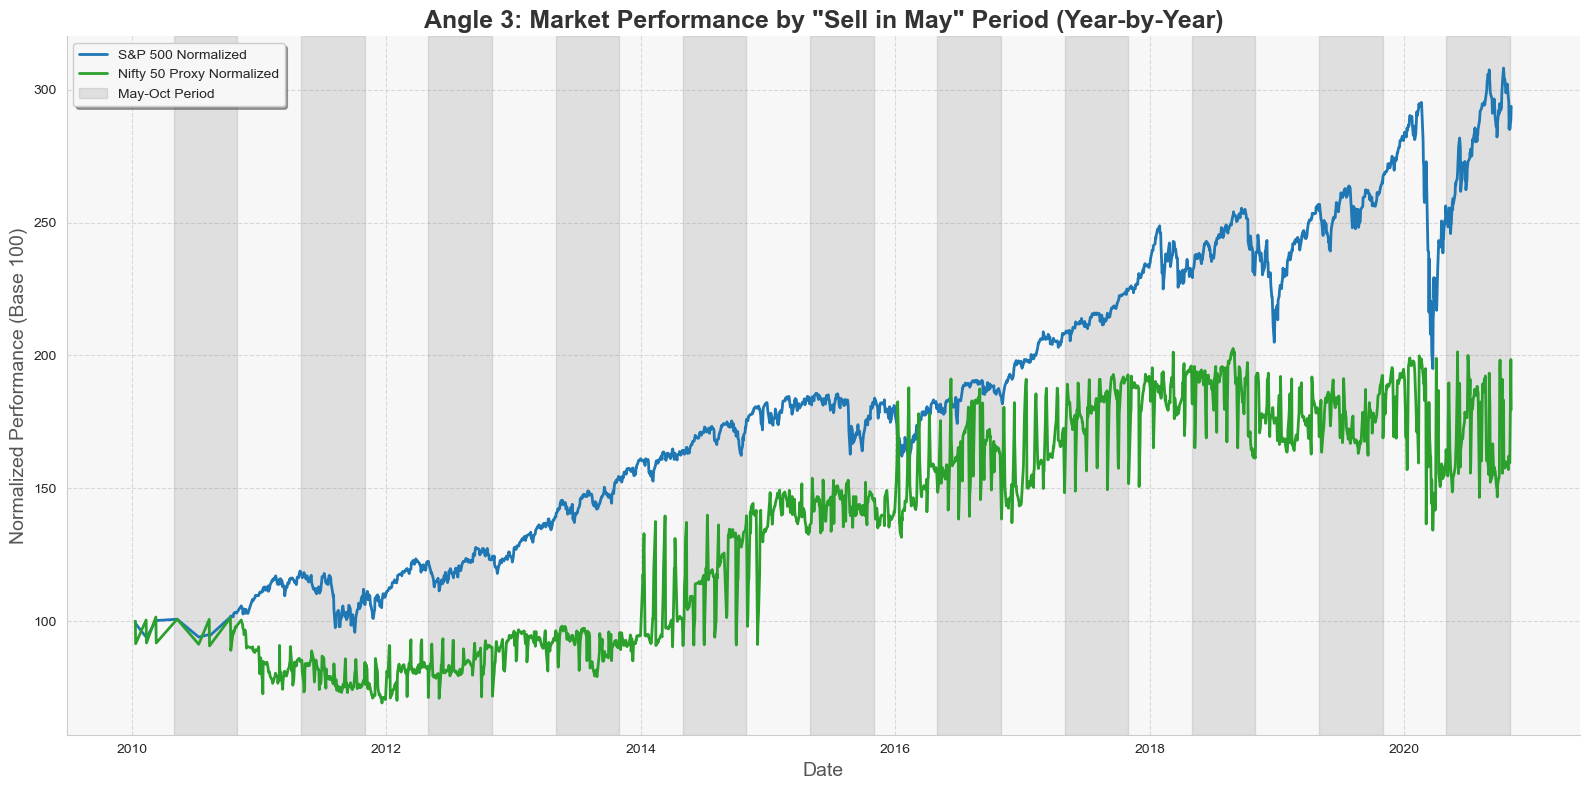

Angle 3: Year-by-Year Comparison Chart generated and saved as 'sell_in_may_angle3_year_by_year.png'


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. Load the Datasets ---
try:
    sp500_df = pd.read_csv('SPX.csv', parse_dates=['Date'])
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
except FileNotFoundError:
    print("Error: Make sure 'SPX.csv' and 'Final-50-stocks.csv' are in the same directory as this script.")
    print("Please ensure the files are correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Data Preprocessing ---

# S&P 500 Data: Select 'Date' and 'Adj Close' and calculate returns
sp500_df = sp500_df[['Date', 'Adj Close']].copy()
sp500_df.columns = ['Date', 'SP500_Close']
sp500_df = sp500_df.sort_values(by='Date').set_index('Date')
sp500_df['SP500_Returns'] = sp500_df['SP500_Close'].pct_change().dropna()

# Nifty 50 Data: Calculate a proxy for Nifty 50 Index and its returns
nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
if 'Date' in stock_tickers:
    stock_tickers.remove('Date')

for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

nifty50_stocks_df['Nifty50_Proxy_Close'] = nifty50_stocks_df[stock_tickers].mean(axis=1)
nifty50_proxy_df = nifty50_stocks_df[['Nifty50_Proxy_Close']].copy()
nifty50_proxy_df.columns = ['Nifty50_Close']
nifty50_proxy_df['Nifty50_Returns'] = nifty50_proxy_df['Nifty50_Close'].pct_change().dropna()

# Merge the datasets on 'Date' (index)
merged_df = pd.merge(sp500_df, nifty50_proxy_df, on='Date', how='inner')

# Filter for relevant date range (Nifty 50 data starts from 2010)
merged_df = merged_df.loc['2010-01-01':]

# --- 3. Define "Sell in May" Periods and Calculate Annual Period Returns ---

# Assign each row to a period: 'May-Oct' or 'Nov-Apr'
merged_df['Month'] = merged_df.index.month
merged_df['Period'] = np.where(
    (merged_df['Month'] >= 5) & (merged_df['Month'] <= 10),
    'May-Oct',
    'Nov-Apr'
)
merged_df['Period_Order'] = np.where(merged_df['Period'] == 'Nov-Apr', 0, 1) # For consistent sorting in plots

# Create a 'Year' column for grouping
merged_df['Year'] = merged_df.index.year

# Calculate daily growth factor (1 + return)
merged_df['SP500_Growth_Factor'] = 1 + (merged_df['SP500_Returns'] / 100)
merged_df['Nifty50_Growth_Factor'] = 1 + (merged_df['Nifty50_Returns'] / 100)

# Calculate cumulative return for each period within each year
period_returns_yearly = merged_df.groupby(['Year', 'Period', 'Period_Order']).apply(
    lambda x: pd.Series({
        'SP500_Cumulative_Return': (x['SP500_Growth_Factor'].prod() - 1) * 100,
        'Nifty50_Cumulative_Return': (x['Nifty50_Growth_Factor'].prod() - 1) * 100
    })
).reset_index()

# Drop any periods/years where the cumulative return calculation resulted in NaN
period_returns_yearly = period_returns_yearly.dropna(subset=['SP500_Cumulative_Return', 'Nifty50_Cumulative_Return'])


# --- Set Global Plotting Style ---
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})


# --- Angle 3: Year-by-Year Comparison with Period Highlights (Line Chart with Shaded Periods) ---

# Re-normalize overall performance to 100 at the start of the data
overall_start_value_sp500 = merged_df['SP500_Close'].iloc[0]
overall_start_value_nifty50 = merged_df['Nifty50_Close'].iloc[0]

merged_df['SP500_Normalized_Overall'] = (merged_df['SP500_Close'] / overall_start_value_sp500) * 100
merged_df['Nifty50_Normalized_Overall'] = (merged_df['Nifty50_Close'] / overall_start_value_nifty50) * 100

fig3, ax3 = plt.subplots(figsize=(16, 8))

# --- CHANGE MADE HERE: Increased linewidth for plot lines ---
ax3.plot(merged_df.index, merged_df['SP500_Normalized_Overall'], label='S&P 500 Normalized', color='#1f77b4', linewidth=2.0)
ax3.plot(merged_df.index, merged_df['Nifty50_Normalized_Overall'], label='Nifty 50 Proxy Normalized', color='#2ca02c', linewidth=2.0)

# Add shaded regions for 'May-Oct' periods
years = merged_df['Year'].unique()
for year in years:
    may_oct_start = pd.to_datetime(f'{year}-05-01')
    may_oct_end = pd.to_datetime(f'{year}-10-31')
    
    # Ensure shading is within data range
    if may_oct_start <= merged_df.index.max() and may_oct_end >= merged_df.index.min():
        # --- CHANGE MADE HERE: Increased alpha for shaded regions ---
        ax3.axvspan(max(may_oct_start, merged_df.index.min()), min(may_oct_end, merged_df.index.max()),
                    color='gray', alpha=0.2, label='May-Oct Period' if year == years[0] else "") # Label only once


ax3.set_title('Angle 3: Market Performance by "Sell in May" Period (Year-by-Year)', fontsize=18, fontweight='bold', color='#333333')
ax3.set_xlabel('Date', fontsize=14, color='#555555')
ax3.set_ylabel('Normalized Performance (Base 100)', fontsize=14, color='#555555')
ax3.grid(True, linestyle='--', alpha=0.7)

# Adjust legend to avoid duplicate 'May-Oct Period' label
handles, labels = ax3.get_legend_handles_labels()
unique_labels = {}
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels[l] = h
ax3.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)


plt.tight_layout()
plt.savefig('sell_in_may_angle3_year_by_year.png')
plt.show()
plt.close(fig3)

print("Angle 3: Year-by-Year Comparison Chart generated and saved as 'sell_in_may_angle3_year_by_year.png'")
